In [1]:
%matplotlib inline

In [2]:
import numpy as np
from nighres import io
import pandas as pd
import gdist
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
df = pd.read_csv('/home/julia/workspace/mouse_gradients/regions.csv')

In [4]:
data_dir = '/home/julia/data/gradients/'

In [5]:
mesh = io.load_mesh(data_dir + 'allen_atlas/annot_finest.vtk')
cortex = np.where(mesh['data']!=0)[0]
gradients = io.load_mesh(data_dir + 'results/embedding/embed_sampled_mesh.vtk')

### Function to separate surface mesh patches

In [6]:
def subcluster_graph(nodes, triangles, clustering):

    # initiate empty graph
    G=nx.Graph()

    # add node indices
    G.add_nodes_from(range(len(nodes)))

    # add edges
    G.add_edges_from(triangles[:,[0,1]])
    G.add_edges_from(triangles[:,[0,2]])
    G.add_edges_from(triangles[:,[1,2]])

    # make an array with one column per cluster, 0 if this node is not in the respective subcluster
    # otherwise number of the sublcuster, therefore, the subclusters have to be one-indexed
    subclust_arr = np.zeros((clustering.shape[0], int(clustering.max()+1)))
    #for each cluster
    for nclust in range(int(clustering.max()+1)):
        # make a subgraph only containing nodes from this cluster
        clustgraph = nx.subgraph(G, np.where(clustering==nclust)[0])
        # find the seperate connected components of this subgraph
        subclust = nx.connected_components(clustgraph)

        count = 0
        for i in subclust:
            for j in i:
                subclust_arr[j][nclust] = count+1
            count += 1

    return subclust_arr

### Calculate center of mass of primary sensory regions

In [7]:
patches = np.zeros_like(mesh['data'])
center_data = np.zeros_like(mesh['data'])
#for a in ['SSp-bfd', 'SSp-m']:
#    idx = df.loc[df['acronym'] == a, 'id'].values[0]
#    patches[np.round(mesh['data'])==idx] = 1
#sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
#patch_a = np.hstack((np.where([sub_patches[:,1]==1])[1], np.where([sub_patches[:,1]==2])[1]))
#patch_b = np.hstack((np.where([sub_patches[:,1]==3])[1], np.where([sub_patches[:,1]==4])[1]))

for a in ['SSp-n','SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-ul', 'SSp-tr', 'SSp-un']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    patches[np.round(mesh['data'])==idx] = 1
sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
patch_a = np.where([sub_patches[:,1]==1])[1]
patch_b = np.where([sub_patches[:,1]==2])[1]

for patch in [patch_a, patch_b]:
    x = mesh['points'][patch][:,0].min() + ((mesh['points'][patch][:,0].max() - mesh['points'][patch][:,0].min())/2)
    y = mesh['points'][patch][:,1].min() + ((mesh['points'][patch][:,1].max() - mesh['points'][patch][:,1].min())/2)
    z = mesh['points'][patch][:,2].min() + ((mesh['points'][patch][:,2].max() - mesh['points'][patch][:,2].min())/2)
    center = np.argmin(np.sqrt(np.sum((mesh['points']-[x,y,z])**2, axis=1)))
    center_data[center] = 1
    
for a in ['VISp', 'AUDp']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    patches = np.zeros_like(mesh['data'])
    patches[np.round(mesh['data'])==idx] = 1
    sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
    patch_a = np.where([sub_patches[:,1]==1])[1]
    patch_b = np.where([sub_patches[:,1]==2])[1]

    for patch in [patch_a, patch_b]:
        x = mesh['points'][patch][:,0].min() + ((mesh['points'][patch][:,0].max() - mesh['points'][patch][:,0].min())/2)
        y = mesh['points'][patch][:,1].min() + ((mesh['points'][patch][:,1].max() - mesh['points'][patch][:,1].min())/2)
        z = mesh['points'][patch][:,2].min() + ((mesh['points'][patch][:,2].max() - mesh['points'][patch][:,2].min())/2)
        center = np.argmin(np.sqrt(np.sum((mesh['points']-[x,y,z])**2, axis=1)))
        center_data[center] = 1

io.save_mesh(data_dir + 'results/sensory_distance/sensory_centers.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':center_data})

### Calculate distance from these centers

In [8]:
source = np.where(center_data==1)[0]
dist = gdist.compute_gdist(np.array(mesh['points'], dtype=np.float64), 
                           np.array(mesh['faces'], dtype=np.int32), 
                           source_indices=np.array(source, dtype=np.int32),
                           target_indices=np.array(cortex, dtype=np.int32))
dist[dist==np.inf] = 0
dist_mesh = np.zeros_like(mesh['data'])
dist_mesh[cortex] = dist[:,np.newaxis]
io.save_mesh(data_dir + 'results/sensory_distance/sensory_centers_dist.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_mesh})

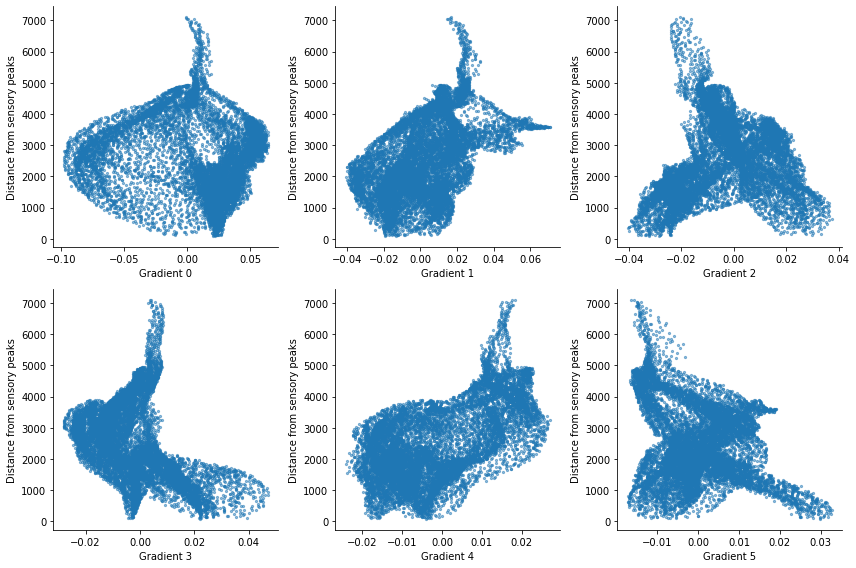

In [9]:
fig = plt.figure(figsize=(12, 8))
for g in range(6):
    fig.add_subplot(2,3,(g+1))
    mask = np.zeros(dist_mesh.shape[0], dtype=np.int16)
    mask[gradients['data'][:,g]!=0]=1
    mask[dist_mesh[:,0]==0]=0
    mask=np.where(mask==1)[0]
    plt.scatter(gradients['data'][:,g][mask], dist_mesh[:,0][mask], alpha=0.5, s=5)
    plt.xlabel('Gradient %s'%g)
    plt.ylabel('Distance from sensory peaks')
    sns.despine()
    plt.tight_layout()